In [1]:
import ast
import copy
import glob
import json
import os
import re
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from sklearn.model_selection import GroupKFold, KFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import copy

import seaborn as sns
import torch
import torchvision
from IPython.display import clear_output

In [2]:
checked_paths = [
    "/app/_data/yolov5/runs/train/yolov5l6_val2/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5l6_val110/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val23/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val1/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val3_3840/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5s6_val3_4480/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val02/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val3_3840/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val02/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5m_val1_1/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val23/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val2/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5s6_val29/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val1/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5l6_val110/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m6_val2/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5s6_val29/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5s6_val3_4480/weights/last.pt",
    "/app/_data/yolov5/runs/train/yolov5m_val1_1/weights/best.pt",
    "/app/_data/yolov5/runs/train/yolov5l6_val2/weights/last.pt",
]

In [3]:
TRAIN_DF_PART = "/app/_data/tensorflow-great-barrier-reef/train.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE
SEED = 42
IMAGE_FOLDER = "norm_images/images"
LABEL_FOLDER = IMAGE_FOLDER.replace("/images", "/labels")

'cuda'

In [4]:
def IOU_coco(bbox1, bbox2):
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y_bottom = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = bbox1[2] * bbox1[3]
    bb2_area = bbox2[2] * bbox2[3]
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    return iou


def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

In [5]:
df = pd.read_csv(TRAIN_DF_PART)
df["img_path"] = (
    "/app/_data/tensorflow-great-barrier-reef/train_images/video_"
    + df.video_id.astype("str")
    + "/"
    + df.video_frame.astype("str")
    + ".jpg"
)
df["annotations"] = df["annotations"].apply(lambda x: ast.literal_eval(x))
df["len_annotation"] = df["annotations"].str.len()
df["image_id"] = df["image_id"].str.replace("-", "_", regex=True)
df["new_img_path"] = f"/app/_data/{IMAGE_FOLDER}/" + df["image_id"] + ".jpg"


df["num_bbox"] = df["len_annotation"]
df["bboxes"] = df.annotations.apply(get_bbox)

In [6]:
df.groupby("video_id")["len_annotation"].sum()

video_id
0    3065
1    6384
2    2449
Name: len_annotation, dtype: int64

## KFold split

In [8]:
paths = list(
    set(glob.glob("/app/_data/yolov5/runs/train/*/*/*.pt")) - set(checked_paths)
)
# paths

In [9]:
eval_IOU = 0.65
res = []
paths = ["/app/_data/yolov5/runs/train/yolov5l6_val2_norm_3000/weights/best.pt"]
for a in range(len(paths)):
    path = paths[a]
    IMG_SIZE = 3000 if "l6" in path else 4480 if "s6" in path else 3840
    model = torch.hub.load(
        "/app/_data/yolov5", "custom", path=path, source="local", force_reload=True
    )  # local repo
    model.conf = 0.01
    VIDEO_ID = int(path[path.index("val") + 3])
    if int(path[path.index("val") + 3]) == 3:
        VIDEO_ID = 0
    df_test = df[df.video_id == VIDEO_ID]
    df_sample = df_test
    image_paths = df_sample.new_img_path.tolist()
    gt = copy.deepcopy(df_sample.bboxes.tolist())
    gtmem = copy.deepcopy(df_sample.bboxes.tolist())
    TP = []  # Confidence scores of true positives
    FP = []  # Confidence scores of true positives
    FN = 0  # Count of false negative boxes
    for i in tqdm(range(len(image_paths))):
        TEST_IMAGE_PATH = image_paths[i]
        img = np.array(Image.open(TEST_IMAGE_PATH))
        prediction = model(img, size=IMG_SIZE, augment=True).xywh[0].cpu().numpy()
        scores = prediction[:, 4]
        bboxes = np.round(prediction[:, :4]).astype("int")
        bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2
        bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2
        gt0 = gt[i]
        if len(bboxes) == 0:
            # all gt are false negative
            FN += len(gt0)
        else:
            bb = bboxes.copy().tolist()
            for idx, b in enumerate(bb):
                b.append(scores[idx])
            bb.sort(key=lambda x: x[4], reverse=True)

            if len(gt0) == 0:
                # all bboxes are false positives
                for b in bb:
                    FP.append(b[4])
            else:
                # match bbox with gt
                for b in bb:
                    matched = False
                    for g in gt0:
                        # check whether gt box is already matched to an inference bb
                        if len(g) == 4:
                            # g bbox is unmatched
                            if IOU_coco(b, g) >= eval_IOU:
                                g.append(
                                    b[4]
                                )  # assign confidence values to g; marks g as matched
                                matched = True
                                TP.append(b[4])
                                break
                    if not matched:
                        FP.append(b[4])
                for g in gt0:
                    if len(g) == 4:
                        FN += 1
    F2list = []
    F2max = 0.0
    F2maxat = -1.0

    for c in np.arange(0.0, 1.0, 0.01):
        FNcount = FN + sum(1 for i in TP if i < c)
        TPcount = sum(1 for i in TP if i >= c)
        FPcount = sum(1 for i in FP if i >= c)
        R = TPcount / (TPcount + FNcount + 0.0001)
        P = TPcount / (TPcount + FPcount + 0.0001)
        F2 = (5 * P * R) / (4 * P + R + 0.0001)
        F2list.append((c, F2))
        if F2max < F2:
            F2max = F2
            F2maxat = c
    res.append([path, IMG_SIZE, np.round(F2max, 3), np.round(F2maxat, 3)])
    print(res)
print(res)

YOLOv5 🚀 v6.0-193-gdb1f83b torch 1.9.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)

Fusing layers... 
Model Summary: 476 layers, 76118664 parameters, 0 gradients
Adding AutoShape... 
100% 8561/8561 [34:19<00:00,  4.16it/s]


[['/app/_data/yolov5/runs/train/yolov5l6_val2_norm_3000/weights/best.pt', 3000, 0.671, 0.41]]
[['/app/_data/yolov5/runs/train/yolov5l6_val2_norm_3000/weights/best.pt', 3000, 0.671, 0.41]]


[['/app/_data/yolov5/runs/train/yolov5m6_val2/weights/last.pt', 4480, 0.691, 0.19],  
['/app/_data/yolov5/runs/train/yolov5m6_val2/weights/best.pt', 4480, 0.7, 0.27],  
['/app/_data/yolov5/runs/train/yolov5l6_val110/weights/last.pt', 2880, 0.538, 0.09],  
['/app/_data/yolov5/runs/train/yolov5l6_val110/weights/best.pt', 2880, 0.589, 0.12],  
['/app/_data/yolov5/runs/train/yolov5s6_val29/weights/last.pt', 3840, 0.698, 0.18],  
['/app/_data/yolov5/runs/train/yolov5s6_val29/weights/best.pt', 3840, 0.705, 0.35],  
['/app/_data/yolov5/runs/train/yolov5l6_val2/weights/last.pt', 2880, 0.711, 0.36],  
['/app/_data/yolov5/runs/train/yolov5l6_val2/weights/best.pt', 2880, 0.734, 0.34],  
['/app/_data/yolov5/runs/train/yolov5m_val1_1/weights/last.pt', 3840, 0.487, 0.05],  
['/app/_data/yolov5/runs/train/yolov5m_val1_1/weights/best.pt', 3840, 0.563, 0.08],  
['/app/_data/yolov5/runs/train/yolov5m6_val23/weights/last.pt', 4480, 0.674, 0.08],  
['/app/_data/yolov5/runs/train/yolov5m6_val23/weights/best.pt', 4480, 0.726, 0.23],  
['/app/_data/yolov5/runs/train/yolov5m6_val1/weights/last.pt', 4480, 0.526, 0.11],  
['/app/_data/yolov5/runs/train/yolov5m6_val1/weights/best.pt', 4480, 0.582, 0.27]]


In [14]:
r = [
    ["/app/_data/yolov5/runs/train/yolov5m6_val2/weights/last.pt", 4480, 0.691, 0.19],
    ["/app/_data/yolov5/runs/train/yolov5m6_val2/weights/best.pt", 4480, 0.7, 0.27],
    ["/app/_data/yolov5/runs/train/yolov5l6_val110/weights/last.pt", 2880, 0.538, 0.09],
    ["/app/_data/yolov5/runs/train/yolov5l6_val110/weights/best.pt", 2880, 0.589, 0.12],
    ["/app/_data/yolov5/runs/train/yolov5s6_val29/weights/last.pt", 3840, 0.698, 0.18],
    ["/app/_data/yolov5/runs/train/yolov5s6_val29/weights/best.pt", 3840, 0.705, 0.35],
    ["/app/_data/yolov5/runs/train/yolov5l6_val2/weights/last.pt", 2880, 0.711, 0.36],
    ["/app/_data/yolov5/runs/train/yolov5l6_val2/weights/best.pt", 2880, 0.734, 0.34],
    ["/app/_data/yolov5/runs/train/yolov5m_val1_1/weights/last.pt", 3840, 0.487, 0.05],
    ["/app/_data/yolov5/runs/train/yolov5m_val1_1/weights/best.pt", 3840, 0.563, 0.08],
    ["/app/_data/yolov5/runs/train/yolov5m6_val23/weights/last.pt", 4480, 0.674, 0.08],
    ["/app/_data/yolov5/runs/train/yolov5m6_val23/weights/best.pt", 4480, 0.726, 0.23],
    ["/app/_data/yolov5/runs/train/yolov5m6_val1/weights/last.pt", 4480, 0.526, 0.11],
    ["/app/_data/yolov5/runs/train/yolov5m6_val1/weights/best.pt", 4480, 0.582, 0.27],
]

In [ ]:
"/app/_data/yolov5/runs/train/yolov5l6_val2/weights/best.pt"
"/app/_data/yolov5/runs/train/yolov5m6_val23/weights/best.pt"

In [11]:
from torchvision.ops import box_iou

In [ ]:
box_iou()

In [ ]:
def calculate_score(preds, gts, iou_th):
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    if (5 * num_tp + 4 * num_fn + num_fp) != 0:
        score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    else:
        score = np.nan
    if (num_tp + num_fn) != 0:
        recall = num_tp / (num_tp + num_fn)
    else:
        recall = np.nan
    if (num_tp + num_fp) != 0:
        precission = num_tp / (num_tp + num_fp)
    else:
        precission = np.nan

    return score, precission, recall

In [12]:
def calculate_score(preds, gts, iou_th):
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    if (5 * num_tp + 4 * num_fn + num_fp) != 0:
        score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    else:
        score = np.nan
    if (num_tp + num_fn) != 0:
        recall = num_tp / (num_tp + num_fn)
    else:
        recall = np.nan
    if (num_tp + num_fp) != 0:
        precission = num_tp / (num_tp + num_fp)
    else:
        precission = np.nan

    return score, precission, recall


def evaluate_f2(confthre):
    scores = []
    prec05 = []
    rec05 = []
    prec03 = []
    rec03 = []
    iou_ths = np.arange(0.3, 0.85, 0.05)
    with torch.no_grad():
        for images, targets in dl_val:
            model.eval()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)

            for i in range(len(images)):
                preds[i]["boxes"] = preds[i]["boxes"].int()
                preds[i]["boxes"] = preds[i]["boxes"][preds[i]["scores"] > confthre]
                score = [
                    calculate_score(
                        preds[i]["boxes"].unsqueeze(0),
                        targets[i]["boxes"].unsqueeze(0),
                        iou_th,
                    )[0]
                    for iou_th in iou_ths
                ]
                scores.append(np.nanmean(score))
                prec05.append(
                    calculate_score(
                        preds[i]["boxes"].unsqueeze(0),
                        targets[i]["boxes"].unsqueeze(0),
                        0.5,
                    )[1]
                )
                prec03.append(
                    calculate_score(
                        preds[i]["boxes"].unsqueeze(0),
                        targets[i]["boxes"].unsqueeze(0),
                        0.3,
                    )[1]
                )
                rec05.append(
                    calculate_score(
                        preds[i]["boxes"].unsqueeze(0),
                        targets[i]["boxes"].unsqueeze(0),
                        0.5,
                    )[2]
                )
                rec03.append(
                    calculate_score(
                        preds[i]["boxes"].unsqueeze(0),
                        targets[i]["boxes"].unsqueeze(0),
                        0.3,
                    )[2]
                )
    print(
        f"F2 Score for confthre , {confthre}, :  {np.nanmean(scores):.3f} Precission .5: {np.nanmean(prec05):.3f} Precission .3: {np.nanmean(prec03):.3f}  Recall .5: {np.nanmean(rec05):.3f} Recall .3: {np.nanmean(rec03):.3f}"
    )

In [13]:
shutil.copytree("/app/_data/YOLOv5_kaggle/yolov5", "/app/_data/yolov5_f2")

'/app/_data/yolov5_f2'

1

In [18]:
shutil.rmtree("/app/_data/YOLOR_images")

In [ ]:
paths = ["/app/_data/yolov5/runs/train/yolov5l6_val1_3000/weights/best.pt"]
for a in range(len(paths)):
    path = paths[a]
    IMG_SIZE = 3008 * 2 if "l6" in path else 4480 * 2 if "s6" in path else 3840 * 2
    model = torch.hub.load(
        "/app/_data/yolov5", "custom", path=path, source="local", force_reload=True
    )
    model.conf = 0.01
    VIDEO_ID = int(path[path.index("val") + 3])
    df_val = df[df.video_id == VIDEO_ID].reset_index(drop=True)
    TP = []  # Confidence scores of true positives
    FP = []  # Confidence scores of false positives
    FN = 0  # Count of false negative boxes
    for ix in tqdm(df_val.index().tolist()):
        img_path = df_val.loc[ix, "img_path"]
        img = np.array(Image.open(img_path))
        prediction = model(img, size=IMG_SIZE, augment=True).xywh[0].cpu().numpy()
        scores = prediction[:, 4]
        bboxes = np.round(prediction[:, :4]).astype("int")
        bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2
        bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2
        bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
        bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
        if df_val.loc[ix, "len_annotation"] == 0:
            if bboxes.size != 0:
                FP.append(scores)
        else:
            gts = np.array([list(x.values()) for x in df_val.loc[ix, "annotations"]])
            gts[:, 2] = gts[:, 2] + gts[:, 0]
            gts[:, 3] = gts[:, 3] + gts[:, 1]
            iou_matrix = box_iou(torch.Tensor(gt), torch.Tensor(box))
            x = torch.where(iou_matrix >= iou_thr)
            tp = np.unique(x[0]).shape[0]
            fp = box.shape[0] - tp
            fn = gt.shape[0] - tp
            sc = np.stack([x[0].cpu().numpy(), scores], 1)
            sc = sc[sc[:, 1].argsort()[::-1]]
            unique_boxes = np.unique(sc[:, 0], return_index=True)[0].astype("int16")
            TP.append(list(sc[unique_boxes, 1]))

In [ ]:
prediction = np.array(
    [
        [307, 581, 334, 611],
        [61, 219, 120, 269],
        [175, 354, 223, 402],
        [173, 314, 214, 345],
        [64, 217, 120, 269],
        [520, 900, 540, 930],
        [62, 219, 120, 269],
    ]
)

In [387]:
def tp_fp_fn(gt, prediction, conf_thr):
    ious = np.arange(0.3, 0.81, 0.05)
    TP, FP, FN = np.zeros(ious.shape[0], 'int16'), np.zeros(ious.shape[0], 'int16'), np.zeros(ious.shape[0], 'int16')
    prediction = prediction[prediction[:, 4] > conf_thr]
    bboxes = prediction[:, :4].astype("int")
    bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2
    bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    if bboxes.size != 0:
        if gt.size == 0:
            fp = bboxes.shape[0]
            FP = np.full(ious.shape[0], fp, 'int16')
        else:
            iou_matrix = box_iou(torch.Tensor(gt), torch.Tensor(bboxes))
            for n, iou_thr in enumerate(ious):
                x = torch.where(iou_matrix >= iou_thr)
                tp = np.unique(x[0]).shape[0]
                fp = bboxes.shape[0] - tp
                fn = gt.shape[0] - tp
                TP[n]= tp
                FP[n] = fp
                FN[n] = fn
    else:
        if gt.size != 0:
            fn = gt.shape[0]
            FN = np.full(ious.shape[0], fn, 'int16')
    return TP, FP, FN

In [382]:
scores = np.zeros(np.arange(0.3, 0.81, 0.05).shape[0])

In [383]:
np.full(8, 5)

array([5, 5, 5, 5, 5, 5, 5, 5])

In [320]:
scores[:]=5
scores

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [340]:
gt = np.array([list(x.values()) for x in df.loc[5476, "annotations"]])
gt[:, 2] = gt[:, 2] + gt[:, 0]
gt[:, 3] = gt[:, 3] + gt[:, 1]
prediction = np.array(
    [
        [320, 596,  27,  30, 0.88],
        [197, 379,  51,  46, 0.84],
        [156, 299,  39,  31, 0.77],
        [194, 329,  39,  31, 0.72],
        [99, 244,  58,  50, 0.55],
        [91, 244,  58,  50, 0.22],
        [781, 356,  27,  31, 0.44],
        [172, 356, 39, 31, 0.33],
    ]
)

In [357]:
gt = np.array([list(x.values()) for x in df.loc[5476, "annotations"]])
# gt[:, 2] = gt[:, 2] + gt[:, 0]
# gt[:, 3] = gt[:, 3] + gt[:, 1]
prediction = np.array(
    [
        [320, 596,  27,  30, 0.3],
        [197, 379,  51,  46, 0.2],
        [156, 299,  39,  31, 0.01],
    ]
)

In [384]:
tp, fp, fn = tp_fp_fn(gt, prediction, 0.3)

In [385]:
iou_matrix

tensor([[0.9286, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9615, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8920],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])

In [386]:
tp, fp, fn

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int8))

In [364]:
if len(fn):
    print(5)

5


In [220]:
np.array([list(x.values()) for x in df.loc[5476, "annotations"]]).shape[0]

5

In [221]:
gt = np.array([list(x.values()) for x in df.loc[5476, "annotations"]])
len(gt)
gt[:, 2] = gt[:, 2] + gt[:, 0]
gt[:, 3] = gt[:, 3] + gt[:, 1]
box = np.array(
    [
        [307, 581, 334, 611],
        [61, 219, 120, 269],
        [175, 354, 223, 402],
        [173, 314, 214, 345],
        [64, 217, 120, 269],
        [520, 900, 540, 930],
        [62, 219, 120, 269],
    ]
)
scores = np.array([0.84, 0.26, 0.65, 0.61, 0.55, 0.45, 0.8])

5

In [237]:
np.array([list(x.values()) for x in df.loc[5476, "annotations"]])

array([[307, 581,  27,  30],
       [172, 356,  51,  46],
       [175, 314,  39,  31],
       [ 62, 219,  58,  50],
       [778, 341,  27,  31]])

In [239]:
prediction = np.array(
    [
        [307, 581, 27, 30, 0.88],
        [172, 356, 51, 46, 0.84],
        [175, 314, 39, 31, 0.77],
        [62, 219, 58, 50, 0.72],
        [778, 341, 27, 31, 0.55],
        [760, 320, 27, 31, 0.22],
        [168, 333, 39, 31, 0.77],
        [176, 316, 39, 31, 0.33],
    ]
)

In [205]:
iou_matrix = box_iou(torch.Tensor(gt), torch.Tensor(box))

In [206]:
iou_thr = 0.3
x = torch.where(iou_matrix >= iou_thr)
tp = np.unique(x[0]).shape[0]
fp = box.shape[0] - tp
fn = gt.shape[0] - tp

In [207]:
tp, fp, fn

(4, 3, 1)

In [208]:
iou_matrix

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9042, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9512, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9831, 0.0000, 0.0000, 0.9296, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [209]:
x

(tensor([0, 1, 2, 3, 3, 3]), tensor([0, 2, 3, 1, 4, 6]))

In [211]:
np.stack([x[0].cpu().numpy(), x[1].cpu().numpy()])

array([[0, 1, 2, 3, 3, 3],
       [0, 2, 3, 1, 4, 6]])

In [178]:
np.stack([x[0].cpu().numpy(), x[1].cpu().numpy(), scores], 1)

ValueError: all input arrays must have the same shape

In [167]:
sc = np.stack([x[0].cpu().numpy(), x[1].cpu().numpy(), scores], 1)
sc = sc[sc[:, 2].argsort()[::-1]]
unique_boxes = np.unique(sc[:, 0], return_index=True)[0].astype("int16")
sc[unique_boxes, 2]

array([0.84, 0.65, 0.61, 0.55])

In [168]:
sc

array([[0.  , 0.  , 0.84],
       [2.  , 3.  , 0.65],
       [3.  , 1.  , 0.61],
       [3.  , 4.  , 0.55],
       [3.  , 6.  , 0.45],
       [1.  , 2.  , 0.26]])

In [169]:
unique_boxes

array([0, 1, 2, 3], dtype=int16)

In [213]:
np.arange(0.3, 0.81, 0.05)

array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ])

In [112]:
x = torch.where(iou_matrix >= 0.3)
if x[0].shape[0]:
    matches = (
        torch.cat((torch.stack(x, 1), iou_matrix[x[0], x[1]][:, None]), 1).cpu().numpy()
    )
    matches = matches[matches[:, 2].argsort()[::-1]]
    matches
    matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
    matches = matches[matches[:, 2].argsort()[::-1]]
    matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
    matches

array([[3.       , 6.       , 1.       ],
       [0.       , 0.       , 1.       ],
       [3.       , 1.       , 0.9830508],
       [2.       , 3.       , 0.9512195],
       [3.       , 4.       , 0.9296149],
       [1.       , 2.       , 0.9041769]], dtype=float32)

array([[0.       , 0.       , 1.       ],
       [1.       , 2.       , 0.9041769],
       [2.       , 3.       , 0.9512195],
       [3.       , 6.       , 1.       ]], dtype=float32)

In [60]:
matches.transpose().astype(np.int16)

array([[0, 1, 2, 3],
       [0, 2, 3, 1],
       [1, 0, 0, 0]], dtype=int16)

In [62]:
gt_classes = [0]
n = matches.shape[0] > 0
m0, m1, _ = matches.transpose().astype(np.int16)
for i, gc in enumerate(gt_classes):
    j = m0 == i
#     if n and sum(j) == 1:
#         self.matrix[detection_classes[m1[j]], gc] += 1  # correct
#     else:
#         self.matrix[self.nc, gc] += 1  # background FP

# if n:
#     for i, dc in enumerate(detection_classes):
#         if not any(m1 == i):
#             self.matrix[dc, self.nc] += 1  # background FN

In [65]:
sum(j) == 1

True

In [185]:
torch.Tensor(gt)
torch.Tensor(box)

tensor([[307., 581., 334., 611.],
        [172., 356., 223., 402.],
        [175., 314., 214., 345.],
        [ 62., 219., 120., 269.],
        [778., 341., 805., 372.]])

tensor([[307., 581., 334., 611.],
        [ 61., 219., 120., 269.],
        [175., 354., 223., 402.],
        [173., 314., 214., 345.],
        [ 64., 217., 120., 269.],
        [520., 900., 540., 930.],
        [ 62., 219., 120., 269.]])

In [198]:
gt = np.array([list(x.values()) for x in df.loc[5476, "annotations"]])
len(gt)
gt[:, 2] = gt[:, 2] + gt[:, 0]
gt[:, 3] = gt[:, 3] + gt[:, 1]
box = np.array(
    [
        [307, 581, 334, 611],
        [61, 219, 120, 269],
        [175, 354, 223, 402],
        [173, 314, 214, 345],
        [64, 217, 120, 269],
        [520, 900, 540, 930],
        [62, 219, 120, 269],
    ]
)
scores = np.array([0.84, 0.26, 0.65, 0.61, 0.55, 0.45, 0.8])
preds = np.zeros([box.shape[0], box.shape[1] + 2])
gt0 = np.zeros([gt.shape[0], gt.shape[1] + 1])
gt0[:, 0] = 0
gt0[:, 1:] = gt
preds[:, :4] = box
preds[:, 4] = scores
preds[:, 5] = 0
preds

5

array([[3.07e+02, 5.81e+02, 3.34e+02, 6.11e+02, 8.40e-01, 0.00e+00],
       [6.10e+01, 2.19e+02, 1.20e+02, 2.69e+02, 2.60e-01, 0.00e+00],
       [1.75e+02, 3.54e+02, 2.23e+02, 4.02e+02, 6.50e-01, 0.00e+00],
       [1.73e+02, 3.14e+02, 2.14e+02, 3.45e+02, 6.10e-01, 0.00e+00],
       [6.40e+01, 2.17e+02, 1.20e+02, 2.69e+02, 5.50e-01, 0.00e+00],
       [5.20e+02, 9.00e+02, 5.40e+02, 9.30e+02, 4.50e-01, 0.00e+00],
       [6.20e+01, 2.19e+02, 1.20e+02, 2.69e+02, 8.00e-01, 0.00e+00]])

In [199]:
gt0

array([[  0., 307., 581., 334., 611.],
       [  0., 172., 356., 223., 402.],
       [  0., 175., 314., 214., 345.],
       [  0.,  62., 219., 120., 269.],
       [  0., 778., 341., 805., 372.]])

In [ ]:
x = torch.where(iou > 0.3)
    if x[0].shape[0]:
        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
        if x[0].shape[0] > 1:
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
    else:
        matches = np.zeros((0, 3))

In [14]:
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])

array([[307, 581, 334, 611],
       [172, 356, 223, 402],
       [175, 314, 214, 345],
       [ 62, 219, 120, 269],
       [778, 341, 805, 372]])

In [19]:
np.where(iou_matrix.max(0)[0] >= 0.3)[0]

array([0, 1, 2, 3, 4])

In [42]:
def bb_iou_array(boxes, new_box):
    # bb interesection over union
    xA = np.maximum(boxes[:, 0], new_box[0])
    yA = np.maximum(boxes[:, 1], new_box[1])
    xB = np.minimum(boxes[:, 2], new_box[2])
    yB = np.minimum(boxes[:, 3], new_box[3])

    interArea = np.maximum(xB - xA, 0) * np.maximum(yB - yA, 0)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    boxBArea = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])

    iou = interArea / (boxAArea + boxBArea - interArea)

    return iou

In [47]:
bb_iou_array(gt, box)

array([          0,     0.85016,           0,           0,           0])

In [48]:
find_matching_box_quickly(gt, box, 0.3, 0.2)

(1, 0.8501577287066246)

In [10]:
eval_IOU = 0.65
res = []
paths = ["/app/_data/yolov5/runs/train/yolov5l6_val1_3000/weights/best.pt"]
for a in range(len(paths)):
    path = paths[a]
    IMG_SIZE = 3008 * 2 if "l6" in path else 4480 * 2 if "s6" in path else 3840 * 2
    model = torch.hub.load(
        "/app/_data/yolov5", "custom", path=path, source="local", force_reload=True
    )
    model.conf = 0.01
    VIDEO_ID = int(path[path.index("val") + 3])

    df_test = df[df.video_id == VIDEO_ID]
    df_sample = df_test
    image_paths = df_sample.img_path.tolist()
    gt = copy.deepcopy(df_sample.bboxes.tolist())
    gtmem = copy.deepcopy(df_sample.bboxes.tolist())
    TP = []  # Confidence scores of true positives
    FP = []  # Confidence scores of true positives
    FN = 0  # Count of false negative boxes
    for i in tqdm(range(len(image_paths))):
        TEST_IMAGE_PATH = image_paths[i]
        img = np.array(Image.open(TEST_IMAGE_PATH))
        prediction = model(img, size=IMG_SIZE, augment=True).xywh[0].cpu().numpy()
        prediction[prediction[:, 4] > 0.01]
        scores = prediction[:, 4]
        bboxes = np.round(prediction[:, :4]).astype("int")
        bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2
        bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2
        gt0 = gt[i]
        if len(bboxes) == 0:
            # all gt are false negative
            FN += len(gt0)
        else:
            bb = bboxes.copy().tolist()
            for idx, b in enumerate(bb):
                b.append(scores[idx])
            bb.sort(key=lambda x: x[4], reverse=True)

            if len(gt0) == 0:
                # all bboxes are false positives
                for b in bb:
                    FP.append(b[4])
            else:
                # match bbox with gt
                for b in bb:
                    matched = False
                    for g in gt0:
                        # check whether gt box is already matched to an inference bb
                        if len(g) == 4:
                            # g bbox is unmatched
                            if IOU_coco(b, g) >= eval_IOU:
                                g.append(
                                    b[4]
                                )  # assign confidence values to g; marks g as matched
                                matched = True
                                TP.append(b[4])
                                break
                    if not matched:
                        FP.append(b[4])
                for g in gt0:
                    if len(g) == 4:
                        FN += 1
    F2list = []
    F2max = 0.0
    F2maxat = -1.0

    for c in np.arange(0.0, 1.0, 0.01):
        FNcount = FN + sum(1 for i in TP if i < c)
        TPcount = sum(1 for i in TP if i >= c)
        FPcount = sum(1 for i in FP if i >= c)
        R = TPcount / (TPcount + FNcount + 0.0001)
        P = TPcount / (TPcount + FPcount + 0.0001)
        F2 = (5 * P * R) / (4 * P + R + 0.0001)
        F2list.append((c, F2))
        if F2max < F2:
            F2max = F2
            F2maxat = c
    res.append([path, IMG_SIZE, np.round(F2max, 3), np.round(F2maxat, 3)])
    print(res)
print(res)

YOLOv5 🚀 v6.0-193-gdb1f83b torch 1.9.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24266MiB)

Fusing layers... 
Model Summary: 476 layers, 76118664 parameters, 0 gradients
Adding AutoShape... 
100% 8232/8232 [1:54:18<00:00,  1.20it/s]


[['/app/_data/yolov5/runs/train/yolov5l6_val1_3000/weights/best.pt', 6016, 0.546, 0.42]]
[['/app/_data/yolov5/runs/train/yolov5l6_val1_3000/weights/best.pt', 6016, 0.546, 0.42]]


In [11]:
paths = glob.glob("/app/_data/yolov5/runs/train/*/*/*.pt")
paths = ["/app/_data/yolov5/runs/train/yolov5l6_val2_30002/weights/best.pt"]

eval_IOU = 0.65
res = []
for a in range(len(paths)):
    path = paths[a]
    IMG_SIZE = 7200 if "l6" in path else 4480 if "s6" in path else 3840 * 3
    model = torch.hub.load(
        "/app/_data/yolov5", "custom", path=path, source="local", force_reload=True
    )  # local repo
    model.conf = 0.01
    VIDEO_ID = int(path[path.index("val") + 3])

    df_test = df[df.video_id == VIDEO_ID]
    df_sample = df_test
    image_paths = df_sample.img_path.tolist()
    gt = copy.deepcopy(df_sample.bboxes.tolist())
    gtmem = copy.deepcopy(df_sample.bboxes.tolist())
    TP = []  # Confidence scores of true positives
    FP = []  # Confidence scores of true positives
    FN = 0  # Count of false negative boxes
    for i in tqdm(range(len(image_paths))):
        TEST_IMAGE_PATH = image_paths[i]
        img = np.array(Image.open(TEST_IMAGE_PATH))
        prediction = model(img, size=IMG_SIZE, augment=True).xywh[0].cpu().numpy()
        scores = prediction[:, 4]
        bboxes = np.round(prediction[:, :4]).astype("int")
        bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2
        bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2
        gt0 = gt[i]
        if len(bboxes) == 0:
            # all gt are false negative
            FN += len(gt0)
        else:
            bb = bboxes.copy().tolist()
            for idx, b in enumerate(bb):
                b.append(scores[idx])
            bb.sort(key=lambda x: x[4], reverse=True)

            if len(gt0) == 0:
                # all bboxes are false positives
                for b in bb:
                    FP.append(b[4])
            else:
                # match bbox with gt
                for b in bb:
                    matched = False
                    for g in gt0:
                        # check whether gt box is already matched to an inference bb
                        if len(g) == 4:
                            # g bbox is unmatched
                            if IOU_coco(b, g) >= eval_IOU:
                                g.append(
                                    b[4]
                                )  # assign confidence values to g; marks g as matched
                                matched = True
                                TP.append(b[4])
                                break
                    if not matched:
                        FP.append(b[4])
                for g in gt0:
                    if len(g) == 4:
                        FN += 1
    F2list = []
    F2max = 0.0
    F2maxat = -1.0

    for c in np.arange(0.0, 1.0, 0.01):
        FNcount = FN + sum(1 for i in TP if i < c)
        TPcount = sum(1 for i in TP if i >= c)
        FPcount = sum(1 for i in FP if i >= c)
        R = TPcount / (TPcount + FNcount + 0.0001)
        P = TPcount / (TPcount + FPcount + 0.0001)
        F2 = (5 * P * R) / (4 * P + R + 0.0001)
        F2list.append((c, F2))
        if F2max < F2:
            F2max = F2
            F2maxat = c
    res.append([path, IMG_SIZE, np.round(F2max, 3), np.round(F2maxat, 3)])
    print(res)
print(res)

YOLOv5 🚀 v6.0-193-gdb1f83b torch 1.9.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24266MiB)

Fusing layers... 
Model Summary: 476 layers, 76118664 parameters, 0 gradients
Adding AutoShape... 
 21% 1758/8561 [34:33<2:13:44,  1.18s/it]


KeyboardInterrupt: 

In [14]:
# Confidence scores of true positives, false positives and count false negatives
eval_IOU = 0.65
IMG_SIZE = 3840
TP = []  # Confidence scores of true positives
FP = []  # Confidence scores of true positives
FN = 0  # Count of false negative boxes
for i in tqdm(range(len(image_paths))):
    TEST_IMAGE_PATH = image_paths[i]
    img = np.array(Image.open(TEST_IMAGE_PATH))
    prediction = model(img, size=IMG_SIZE, augment=True).xywh[0].cpu().numpy()
    scores = prediction[:, 4]
    bboxes = np.round(prediction[:, :4]).astype("int")
    bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2] / 2
    bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3] / 2

    gt0 = gt[i]
    if len(bboxes) == 0:
        # all gt are false negative
        FN += len(gt0)
    else:
        bb = bboxes.copy().tolist()
        for idx, b in enumerate(bb):
            b.append(scores[idx])
        bb.sort(key=lambda x: x[4], reverse=True)

        if len(gt0) == 0:
            # all bboxes are false positives
            for b in bb:
                FP.append(b[4])
        else:
            # match bbox with gt
            for b in bb:
                matched = False
                for g in gt0:
                    # check whether gt box is already matched to an inference bb
                    if len(g) == 4:
                        # g bbox is unmatched
                        if IOU_coco(b, g) >= eval_IOU:
                            g.append(
                                b[4]
                            )  # assign confidence values to g; marks g as matched
                            matched = True
                            TP.append(b[4])
                            break
                if not matched:
                    FP.append(b[4])
            for g in gt0:
                if len(g) == 4:
                    FN += 1

100% 8232/8232 [34:40<00:00,  3.96it/s]


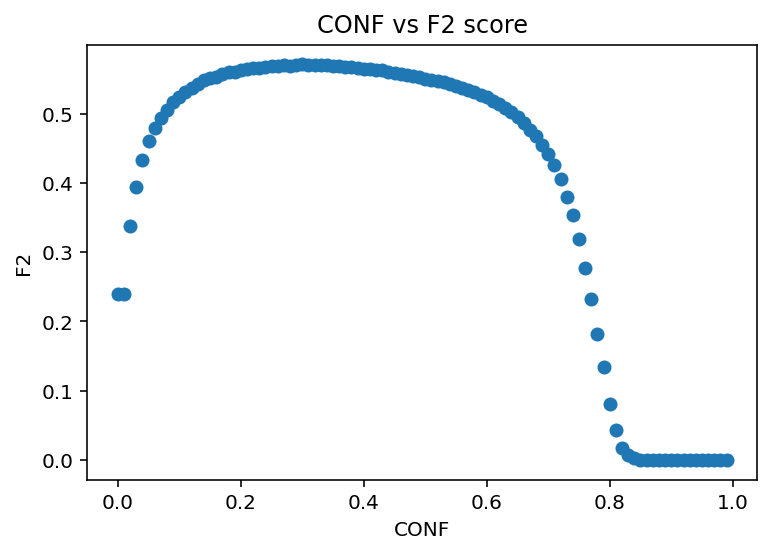

In [15]:
%matplotlib inline
F2list = []
F2max = 0.0
F2maxat = -1.0

for c in np.arange(0.0, 1.0, 0.01):
    FNcount = FN + sum(1 for i in TP if i < c)
    TPcount = sum(1 for i in TP if i >= c)
    FPcount = sum(1 for i in FP if i >= c)
    R = TPcount / (TPcount + FNcount + 0.0001)
    P = TPcount / (TPcount + FPcount + 0.0001)
    F2 = (5 * P * R) / (4 * P + R + 0.0001)
    F2list.append((c, F2))
    if F2max < F2:
        F2max = F2
        F2maxat = c

plt.scatter(*zip(*F2list))
plt.title("CONF vs F2 score")
plt.xlabel("CONF")
plt.ylabel("F2")
plt.show();

In [16]:
print(
    f"F2 max is {np.round(F2max,3)} at CONF = {np.round(F2maxat,3)} for model {path} and image size {IMG_SIZE}"
)

F2 max is 0.571 at CONF = 0.3 for model /app/_data/YOLOv5Weights/best5m63840_val1.pt and image size 3840


F2 max is 0.571 at CONF = 0.3 for model /app/_data/YOLOv5Weights/best5m63840_val1.pt and image size 3840
